In [243]:
import pandas as pd
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt 
import lightgbm as lgbm
import warnings
import seaborn as sns


### Helper Functions

In [244]:
def wap(df):
        return (df['bid_price1'] * df['ask_size1'] +
                df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])

def wap2(df):
    return (df['bid_price2'] * df['ask_size2'] +
            df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(returns):
    return np.sqrt(np.sum(returns ** 2))

def count_unique(series):
    return len(np.unique(series))

def isValidStock(i):
    filename = "stock_trade_train/stock_" + str(i) + "_train.parquet"
    if not os.path.exists(filename):
        return False
    return True

def RMSPEMetric():

    def RMSPE(yhat, dtrain):
        y = dtrain.get_label()
        elements = ((y - yhat) / y) ** 2
        return 'RMSPE', float(np.sqrt(np.sum(elements) / len(y))), False

    return RMSPE

### Getting Dataset

In [245]:
global test
global test1
def book_predictors(stock_id, train_or_test):
    stock_data = pd.read_parquet('stock_book_' + train_or_test + '/stock_' + str(stock_id) + '_' + train_or_test + '.parquet')

    #Only consider last 5 mins of data for all book predictors
    #stock_data = stock_data[stock_data["seconds_in_bucket"] >= 300] #Only consider seconds_in_bucket > 300 

    stock_data['wap'] = wap(stock_data)
    stock_data['log_return'] = stock_data.groupby('time_id')['wap'].apply(log_return)
    stock_data['wap2'] = wap2(stock_data)
    stock_data['log_return2'] = stock_data.groupby('time_id')['wap2'].apply(log_return)
    stock_data['wap_offset'] = abs(stock_data['wap'] - stock_data['wap2'])
    stock_data['price_spread'] = (stock_data['ask_price1'] - stock_data['bid_price1']) / ((stock_data['ask_price1'] + stock_data['bid_price1']) / 2)
    stock_data['bid_spread'] = stock_data['bid_price1'] - stock_data['bid_price2']
    stock_data['ask_spread'] = stock_data['ask_price1'] - stock_data['ask_price2']
    stock_data['total_volume'] = (stock_data['ask_size1'] + stock_data['ask_size2']) + (stock_data['bid_size1'] + stock_data['bid_size2'])
    stock_data['volume_imbalance'] = abs((stock_data['ask_size1'] + stock_data['ask_size2']) - (stock_data['bid_size1'] + stock_data['bid_size2']))

    #Adding features 


    create_feature_dict = {
            'log_return':[realized_volatility],
            'log_return2':[realized_volatility],
            'wap_offset':[np.mean],
            'price_spread':[np.mean],
            'bid_spread':[np.mean],
            'ask_spread':[np.mean],
            'volume_imbalance':[np.mean],
            'total_volume':[np.mean],
            'wap':[np.mean],
    }

    result = pd.DataFrame(stock_data.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    result.columns = result.columns.map('_'.join).str.strip('_')

    return result

def trade_predictors(stock_id, train_or_test):
    stock_data = pd.read_parquet('stock_trade_' + train_or_test + '/stock_' + str(stock_id) + '_' + train_or_test + '.parquet')

    stock_data['log_return'] = stock_data.groupby('time_id')['price'].apply(log_return)

    #3. Percent Range
    #compute price range by time id
    #price_range_by_time_id = stock_data.groupby(['time_id']).max()['price'] - stock_data.groupby(['time_id']).min()['price']
    stock_data['price_max'] = stock_data["price"]
    stock_data['price_min'] = stock_data["price"]
    stock_data['price_median'] = stock_data["price"]


    #current_percent_range = range_trade_price_stock / median_trade_price_stock for each time id what is the percentage range traded --> Get price range for each time id and divide by median price
    # stock_data['current_percent_range'] = price_range_by_time_id / stock_data.groupby(['time_id']).median()['price']

    # #4. Relative Percent Range
    # #a. Compute the current price range by time id
    
    # #a. Compute the average percent range across all time id's
    # avg_percent_range = (price_range_by_time_id / stock_data.groupby(['time_id']).median()['price']).mean()

    # #b. Make a new column of relative percent range... I.e. current/average
    # stock_data['rel_percent_range'] = price_range_by_time_id / avg_percent_range   

    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum], 
        'price_max':[np.max],
        'price_min':[np.min],
        'price_median':[np.median],
    }
    global test
    result = pd.DataFrame(stock_data.groupby('time_id').agg(aggregate_dictionary)).reset_index()
    test = result
    result["size_per_order"] = result["size"] / result["order_count"] 

    avg_trade_volume = result["size"].mean()
    result["rel_trade_volume"] = result["size"] / avg_trade_volume
    print("debug1")
    result['current_percent_range'] = (result["price_max"].values - result["price_min"].values) / result["price_median"]
    print("debug2")
    avg_percent_range = result['current_percent_range'].mean()
    result['rel_percent_range'] = result['current_percent_range'] /  avg_percent_range
    result['stock_id'] = stock_id

    global test1
    test1 = result
    result.drop(columns=['price_max','price_min', 'price_median'], inplace=True)

    result.columns = result.columns.map('_'.join).str.strip('_')
    return result

def target(stock_id, train_or_test):
    result = pd.read_parquet('target_data/target_' + train_or_test + '.parquet')
    result = result.loc[result['stock_id'] == stock_id]
    result = result.drop(['stock_id'], axis = 1)
    return result

def generate_data(stock_id, train_or_test):
    result = pd.merge(target(stock_id, train_or_test), book_predictors(stock_id, train_or_test), on='time_id', how='left')
    result = pd.merge(result, trade_predictors(stock_id, train_or_test), on='time_id', how='left')
    return result

def generate_train_and_test(stock_id):
    train = generate_data(stock_id, 'train')
    test = generate_data(stock_id, 'test')

    X_train = train.drop(['target', 'time_id'], axis = 1)
    X_test = test.drop(['target', 'time_id'], axis = 1)

    y_train = train['target']
    y_test = test['target']

    return X_train, X_test, y_train, y_test

### Getting combined Dataframes

In [246]:
total = 0
total_size = 0
warnings.filterwarnings("ignore")

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for i in range(127):
    if not isValidStock(i):
        continue

    a, b, c, d = generate_train_and_test(i)

    X_train = pd.concat([X_train, a])
    X_test = pd.concat([X_test, b])
    y_train = pd.concat([y_train, c])
    y_test = pd.concat([y_test, d])


debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1
debug2
debug1

In [247]:
X_train

,log_return_realized_volatility_x,log_return2_realized_volatility,wap_offset_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_y,seconds_in_bucket_count_unique,size_sum,order_count_sum,size_per_order,rel_trade_volume,current_percent_range,rel_percent_range,stock_id
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002006,40.0,3179.0,110.0,28.900000,0.987225,0.002370,0.709720,0.0
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000901,30.0,1289.0,57.0,22.614035,0.400294,0.001104,0.330628,0.0
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001961,25.0,2161.0,68.0,31.779412,0.671089,0.003065,0.917991,0.0
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001561,15.0,1962.0,59.0,33.254237,0.609291,0.002261,0.677207,0.0
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.000871,22.0,1791.0,89.0,20.123596,0.556188,0.000793,0.237425,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.003017,0.005136,0.000244,0.000596,0.000193,-0.000146,159.887550,425.493976,0.997105,0.002195,45.0,5059.0,131.0,38.618321,0.943226,0.004275,0.922835,126.0
3061,0.002858,0.004733,0.000382,0.000753,0.000141,-0.000167,122.798780,349.432927,0.998307,0.001273,17.0,2185.0,84.0,26.011905,0.407383,0.002174,0.469397,126.0
3062,0.007472,0.012533,0.000637,0.001302,0.000485,-0.000300,114.021505,381.887097,0.997042,0.005587,72.0,7981.0,181.0,44.093923,1.488019,0.009658,2.085007,126.0
3063,0.001467,0.002508,0.000235,0.000517,0.000101,-0.000151,304.453202,537.192118,1.000273,0.000851,19.0,1783.0,49.0,36.387755,0.332432,0.001084,0.234093,126.0


### Implementing LGBM

In [248]:
params_lgbm = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'objective': 'rmse',
        'n_jobs': 8,
        'verbose': -1
    }
weights = 1/(y_train[0] ** 2)
lgbm_train_data = lgbm.Dataset(X_train, label=y_train[0], weight=weights)

weights = 1/(y_test[0] ** 2)
lgbm_test_data = lgbm.Dataset(X_test, label=y_test[0], weight=weights)
rounds = 100000
model = lgbm.train(params_lgbm, 
                    lgbm_train_data, 
                    rounds, 
                    valid_sets=lgbm_test_data,
                    feval=RMSPEMetric(),
                    verbose_eval = 500,
                    early_stopping_rounds=10000,
                    categorical_feature = ['stock_id']
                    )

Training until validation scores don't improve for 10000 rounds
[500]	valid_0's l2: 2.64042e-07	valid_0's RMSPE: 0.242225
[1000]	valid_0's l2: 2.61546e-07	valid_0's RMSPE: 0.241078
[1500]	valid_0's l2: 2.60727e-07	valid_0's RMSPE: 0.2407
[2000]	valid_0's l2: 2.59983e-07	valid_0's RMSPE: 0.240356
[2500]	valid_0's l2: 2.596e-07	valid_0's RMSPE: 0.240179
[3000]	valid_0's l2: 2.59582e-07	valid_0's RMSPE: 0.240171
[3500]	valid_0's l2: 2.59374e-07	valid_0's RMSPE: 0.240075
[4000]	valid_0's l2: 2.594e-07	valid_0's RMSPE: 0.240087
[4500]	valid_0's l2: 2.59593e-07	valid_0's RMSPE: 0.240176
[5000]	valid_0's l2: 2.59883e-07	valid_0's RMSPE: 0.24031
[5500]	valid_0's l2: 2.60282e-07	valid_0's RMSPE: 0.240495
[6000]	valid_0's l2: 2.60835e-07	valid_0's RMSPE: 0.24075
[6500]	valid_0's l2: 2.61093e-07	valid_0's RMSPE: 0.240869
[7000]	valid_0's l2: 2.61331e-07	valid_0's RMSPE: 0.240979
[7500]	valid_0's l2: 2.61684e-07	valid_0's RMSPE: 0.241141
[8000]	valid_0's l2: 2.61839e-07	valid_0's RMSPE: 0.241212
[

In [249]:
X_train

,log_return_realized_volatility_x,log_return2_realized_volatility,wap_offset_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_y,seconds_in_bucket_count_unique,size_sum,order_count_sum,size_per_order,rel_trade_volume,current_percent_range,rel_percent_range,stock_id
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002006,40.0,3179.0,110.0,28.900000,0.987225,0.002370,0.709720,0.0
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000901,30.0,1289.0,57.0,22.614035,0.400294,0.001104,0.330628,0.0
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001961,25.0,2161.0,68.0,31.779412,0.671089,0.003065,0.917991,0.0
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001561,15.0,1962.0,59.0,33.254237,0.609291,0.002261,0.677207,0.0
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.000871,22.0,1791.0,89.0,20.123596,0.556188,0.000793,0.237425,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.003017,0.005136,0.000244,0.000596,0.000193,-0.000146,159.887550,425.493976,0.997105,0.002195,45.0,5059.0,131.0,38.618321,0.943226,0.004275,0.922835,126.0
3061,0.002858,0.004733,0.000382,0.000753,0.000141,-0.000167,122.798780,349.432927,0.998307,0.001273,17.0,2185.0,84.0,26.011905,0.407383,0.002174,0.469397,126.0
3062,0.007472,0.012533,0.000637,0.001302,0.000485,-0.000300,114.021505,381.887097,0.997042,0.005587,72.0,7981.0,181.0,44.093923,1.488019,0.009658,2.085007,126.0
3063,0.001467,0.002508,0.000235,0.000517,0.000101,-0.000151,304.453202,537.192118,1.000273,0.000851,19.0,1783.0,49.0,36.387755,0.332432,0.001084,0.234093,126.0


### Calculating feature importance

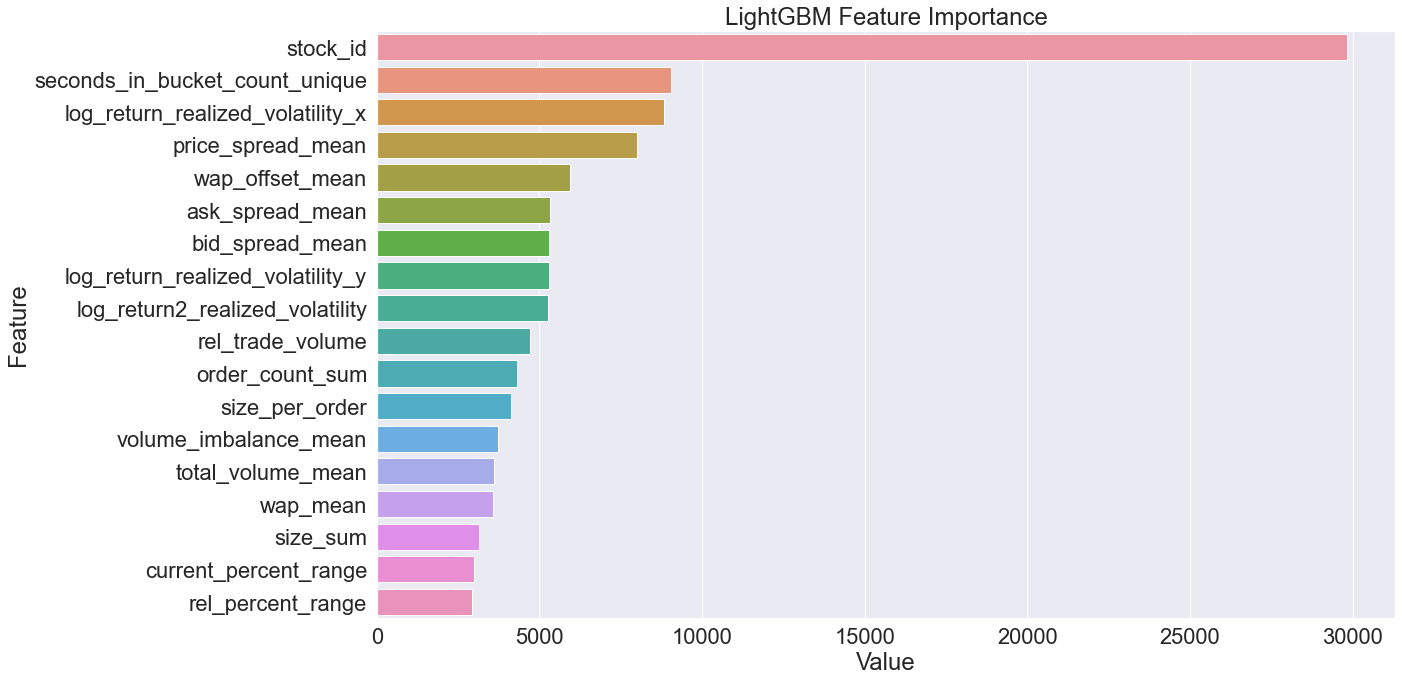

In [252]:
def plotImp(model, X , num = 20, fig_size = (20, 10)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('LightGBM Feature Importance')
    plt.tight_layout()
    plt.show()

plotImp(model, X_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

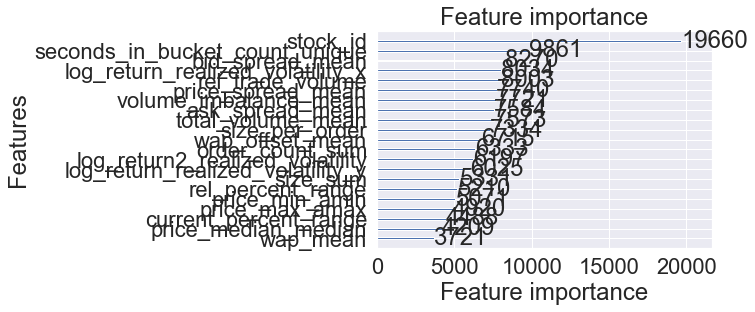

In [251]:
lgbm.plot_importance(clf)